In [1]:
# ================== CARGA DE LIBRERÍAS ================== #

# Desactivar advertencias innecesarias
import warnings
warnings.filterwarnings("ignore")

# Manipulación de datos
import numpy as np
import pandas as pd
import datetime as dt

# Finanzas y datos de mercado
import yfinance as yf
import ta

# Visualización de datos
import matplotlib.pyplot as plt

# Modelos de series temporales y estadística
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.stattools import adfuller, kpss
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

# Machine Learning
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, accuracy_score
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBRegressor

# Optimización de hiperparámetros
import optuna

# Descarga y Preparación de Datos

In [2]:
# ================== DATOS DEL ACTIVO ================== #
# Descarga de datos de AAPL para los últimos 3 años con intervalo diario
stock_ticker = "AAPL"
end_date = dt.datetime.now().date()
start_date = end_date - dt.timedelta(days=3*365)
stock_data = yf.download(stock_ticker, start=start_date, end=end_date, interval="1d")
print("\nDataset original:")
print(stock_data.head())

[*********************100%***********************]  1 of 1 completed


Dataset original:
Price                       Adj Close       Close        High         Low  \
Ticker                           AAPL        AAPL        AAPL        AAPL   
Date                                                                        
2022-02-03 00:00:00+00:00  170.113419  172.899994  176.240005  172.119995   
2022-02-04 00:00:00+00:00  169.827728  172.389999  174.100006  170.679993   
2022-02-07 00:00:00+00:00  169.108566  171.660004  173.949997  170.949997   
2022-02-08 00:00:00+00:00  172.231476  174.830002  175.350006  171.429993   
2022-02-09 00:00:00+00:00  173.659912  176.279999  176.649994  174.899994   

Price                            Open    Volume  
Ticker                           AAPL      AAPL  
Date                                             
2022-02-03 00:00:00+00:00  174.479996  89418100  
2022-02-04 00:00:00+00:00  171.679993  82465400  
2022-02-07 00:00:00+00:00  172.860001  77251200  
2022-02-08 00:00:00+00:00  171.729996  74829200  
2022-02-09 00:

In [3]:
# ================== PREPROCESADO DE DATOS ================== #
stock_data.columns = ['Adj_Close', 'Close', 'High', 'Low', 'Open', 'Volume']
stock_data.index = stock_data.index.tz_localize(None)
stock_data.drop(columns=['Close', 'High', 'Low', 'Open', 'Volume'], inplace=True)
print("\nDataset preprocesado:")
print(stock_data.tail())
bk_stock_data = stock_data.copy()


Dataset preprocesado:
             Adj_Close
Date                  
2025-01-27  229.860001
2025-01-28  238.259995
2025-01-29  239.360001
2025-01-30  237.589996
2025-01-31  236.000000


In [4]:
# ==================  INDICADORES TÉCNICOS Y CARACTERÍSTICAS TEMPORALES ================== #
def calculate_indicators(df):
    """Calcula los indicadores técnicos correctamente y los devuelve"""
    df['SMA_10'] = df['Adj_Close'].rolling(window=10, min_periods=1).mean()
    df['EMA_20'] = df['Adj_Close'].ewm(span=20, adjust=False).mean()
    df['RSI'] = ta.momentum.RSIIndicator(df['Adj_Close'], window=14).rsi()
    df['MACD'] = ta.trend.MACD(df['Adj_Close']).macd()
    df.fillna(method="ffill", inplace=True) 
    return df

def create_features(df):
    """Agrega características temporales al DataFrame"""
    df = df.copy()
    df['dayofweek'] = df.index.dayofweek
    #df['quarter'] = df.index.quarter
    df['month'] = df.index.month
    df['year'] = df.index.year
    df['dayofyear'] = df.index.dayofyear
    df['dayofmonth'] = df.index.day
    df['weekofyear'] = df.index.isocalendar().week
    return df

# Aplicar indicadores y características temporales 
stock_data = calculate_indicators(stock_data)
stock_data = create_features(stock_data)
stock_data['Prediction'] = np.nan  # Columna para predicciones en los datos históricos
stock_data['isFuture'] = False  # Indica que estos son datos históricos

print("\nDataset con indicadores y características temporales:")
print(stock_data.tail())


Dataset con indicadores y características temporales:
             Adj_Close      SMA_10      EMA_20        RSI      MACD  \
Date                                                                  
2025-01-27  229.860001  228.655998  234.388846  42.207213 -5.227918   
2025-01-28  238.259995  229.041998  234.757527  52.280250 -4.234714   
2025-01-29  239.360001  229.649998  235.195858  53.425076 -3.320554   
2025-01-30  237.589996  229.621999  235.423871  51.292713 -2.707687   
2025-01-31  236.000000  230.395999  235.478740  49.385827 -2.323502   

            dayofweek  month  year  dayofyear  dayofmonth  weekofyear  \
Date                                                                    
2025-01-27          0      1  2025         27          27           5   
2025-01-28          1      1  2025         28          28           5   
2025-01-29          2      1  2025         29          29           5   
2025-01-30          3      1  2025         30          30           5   
2025-01-3

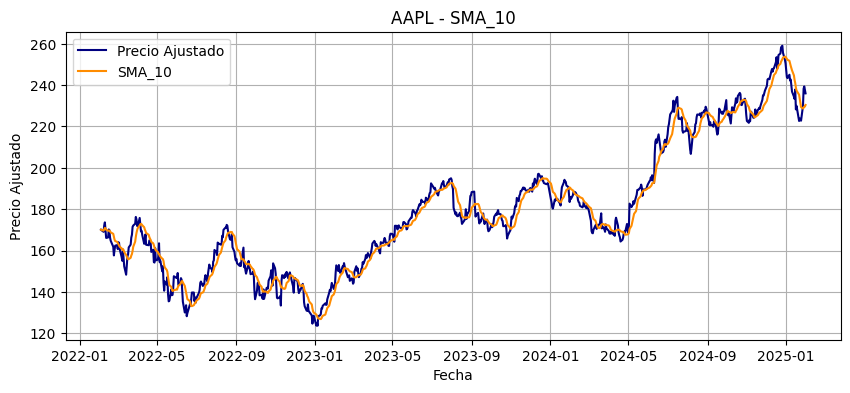

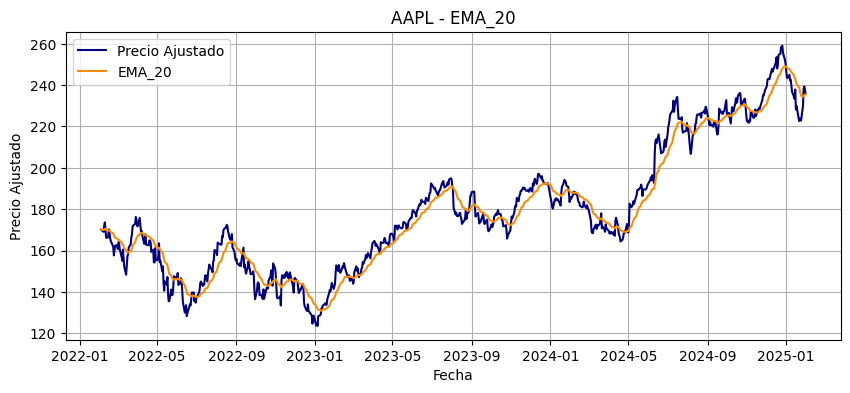

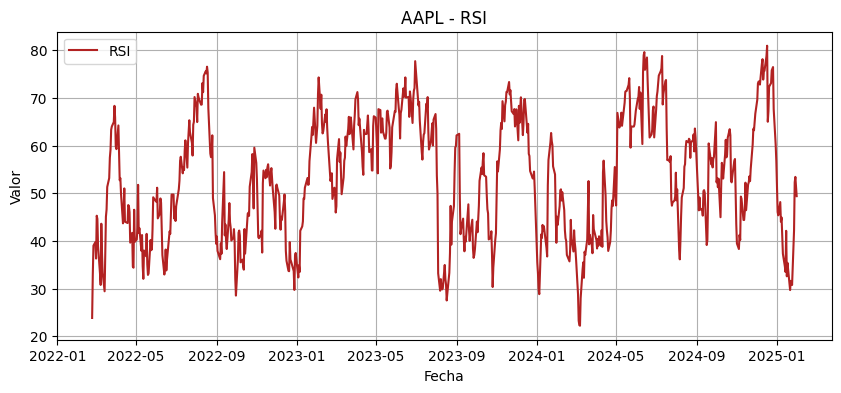

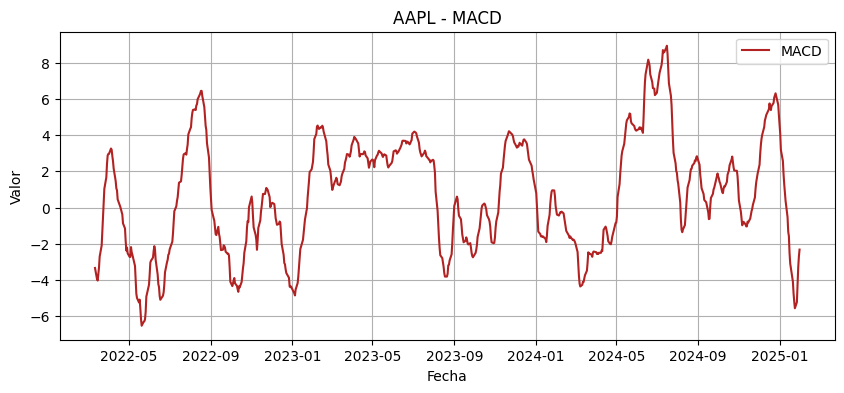

In [5]:
# ================== VISUALIZACIÓN DE INDICADORES ================== #
# Gráfico de indicadores técnicos para SMA y EMA
for indicator in ['SMA_10', 'EMA_20']:
    plt.figure(figsize=(10, 4))
    plt.plot(stock_data['Adj_Close'], label='Precio Ajustado', color='navy')
    plt.plot(stock_data[indicator], label=indicator, color='darkorange')
    plt.title(f'{stock_ticker} - {indicator}')
    plt.xlabel('Fecha')
    plt.ylabel('Precio Ajustado')
    plt.legend()
    plt.grid()
    plt.show()

# Gráfico de indicadores técnicos para RSI y MACD
for indicator in ['RSI', 'MACD']:
    plt.figure(figsize=(10, 4))
    plt.plot(stock_data[indicator], label=indicator, color='firebrick')
    plt.title(f'{stock_ticker} - {indicator}')
    plt.xlabel('Fecha')
    plt.ylabel('Valor')
    plt.legend()
    plt.grid()
    plt.show()


# ARIMA

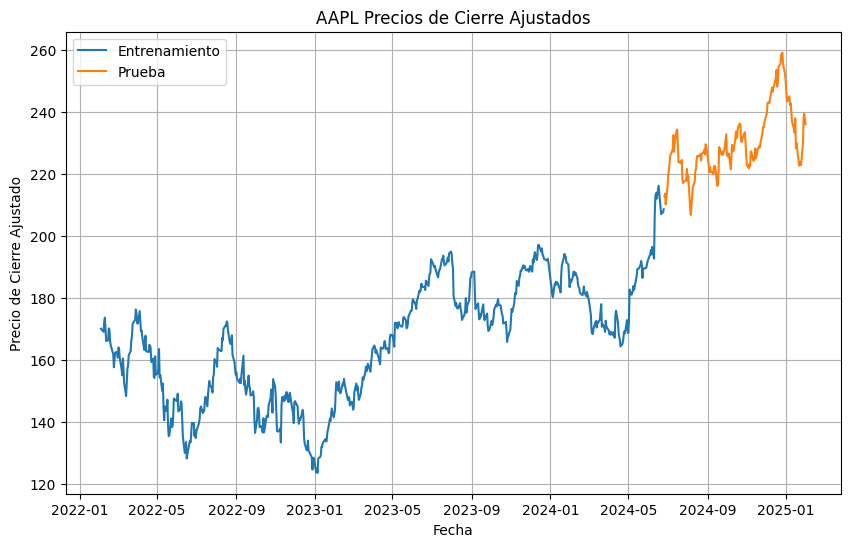

In [6]:
# ================== DIVISIÓN DE DATOS ================== #
# Trabajaremos con una copia del dataset original para el análisis de ARIMA
data = bk_stock_data.copy()

# Eliminar filas con valores nulos
data.dropna(inplace=True)

# Dividir en entrenamiento y prueba (80%-20%)
train_size = int(len(data) * 0.80)
train_data = data.iloc[:train_size]
test_data = data.iloc[train_size:]

# Gráfico de entrenamiento y prueba
plt.figure(figsize=(10, 6))
plt.title(f'{stock_ticker} Precios de Cierre Ajustados')
plt.plot(train_data['Adj_Close'], label='Entrenamiento')
plt.plot(test_data['Adj_Close'], label='Prueba')
plt.xlabel('Fecha')
plt.ylabel('Precio de Cierre Ajustado')
plt.legend()
plt.grid()
plt.show()

In [7]:
# ================= ANÁLISIS DE ESTACIONARIEDAD ================= #	

# Fuente de datos: https://cienciadedatos.net/documentos/py51-modelos-arima-sarimax-python

# Aplicar diferencias para obtener series transformadas
primera_diferencia = train_data['Adj_Close'].diff().dropna()
segunda_diferencia = primera_diferencia.diff().dropna()

# Función para evaluar estacionariedad con ADF y KPSS
def test_stationarity(series, name='Serie'):
    resultado_adf = adfuller(series)
    resultado_kpss = kpss(series)

    print(f'{name} - ADF Statistic: {resultado_adf[0]}, p-value: {resultado_adf[1]}')
    print(f'{name} - KPSS Statistic: {resultado_kpss[0]}, p-value: {resultado_kpss[1]}')

    if resultado_adf[1] < 0.05:
        print(f'{name} es estacionaria según ADF.')
    else:
        print(f'{name} NO es estacionaria según ADF.')
    
    if resultado_kpss[1] < 0.05:
        print(f'{name} NO es estacionaria según KPSS.')
    else:
        print(f'{name} es estacionaria según KPSS.')


Evaluación de estacionariedad: Serie original
---------------------------------------------
Serie original - ADF Statistic: -1.1163052465697736, p-value: 0.7085259544213782
Serie original - KPSS Statistic: 2.1427114164897305, p-value: 0.01
Serie original NO es estacionaria según ADF.
Serie original NO es estacionaria según KPSS.

Evaluación de estacionariedad: Diferenciación de primer orden
-------------------------------------------------------------
Primera diferencia - ADF Statistic: -24.197765364761185, p-value: 0.0
Primera diferencia - KPSS Statistic: 0.15663717177776623, p-value: 0.1
Primera diferencia es estacionaria según ADF.
Primera diferencia es estacionaria según KPSS.

Evaluación de estacionariedad: Diferenciación de segundo orden
--------------------------------------------------------------
Segunda diferencia - ADF Statistic: -10.243510185765837, p-value: 4.6822021778548165e-18
Segunda diferencia - KPSS Statistic: 0.1489329459782972, p-value: 0.1
Segunda diferencia es es

C:\Users\ramon\AppData\Local\Temp\ipykernel_39632\3654585795.py:12: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  resultado_kpss = kpss(series)
C:\Users\ramon\AppData\Local\Temp\ipykernel_39632\3654585795.py:12: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  resultado_kpss = kpss(series)
C:\Users\ramon\AppData\Local\Temp\ipykernel_39632\3654585795.py:12: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  resultado_kpss = kpss(series)


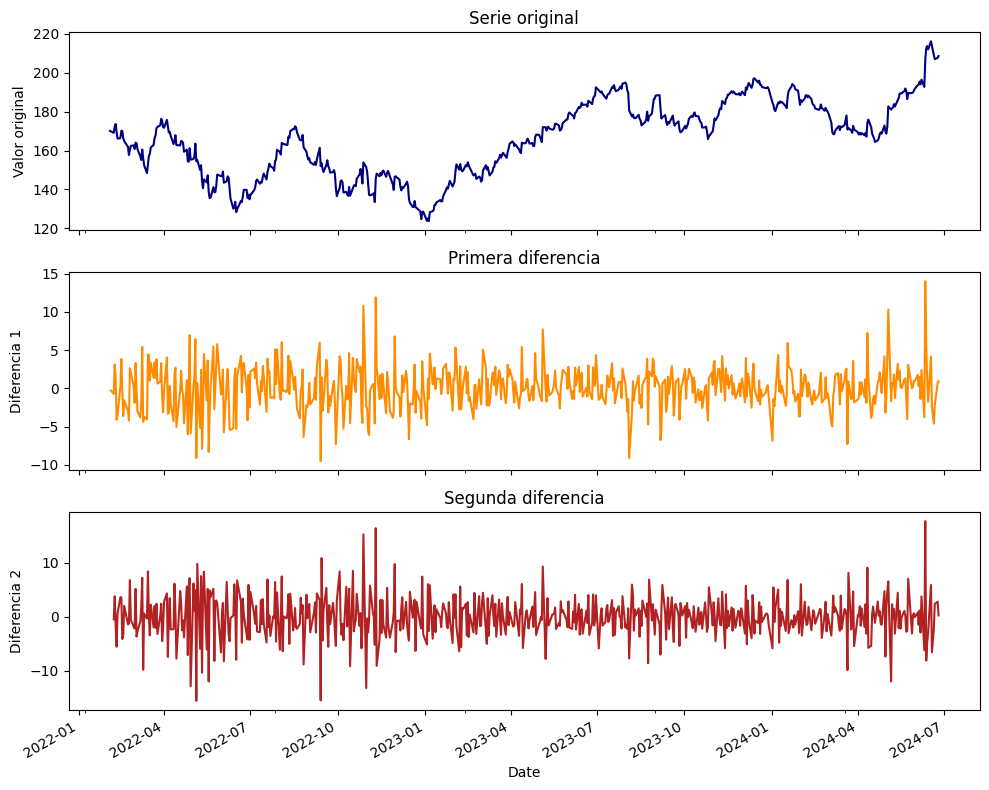

In [8]:
# ================== PRUEBAS DE ESTACIONARIEDAD ================== #

# Prueba de estacionariedad para la serie original
print('Evaluación de estacionariedad: Serie original')
print('---------------------------------------------')
test_stationarity(train_data['Adj_Close'], 'Serie original')

# Prueba de estacionariedad para la primera diferencia
print('\nEvaluación de estacionariedad: Diferenciación de primer orden')
print('-------------------------------------------------------------')
test_stationarity(primera_diferencia, 'Primera diferencia')

# Prueba de estacionariedad para la segunda diferencia
print('\nEvaluación de estacionariedad: Diferenciación de segundo orden')
print('--------------------------------------------------------------')
test_stationarity(segunda_diferencia, 'Segunda diferencia')

# Visualización de las series
# ========================================================================
fig, ejes = plt.subplots(nrows=3, ncols=1, figsize=(10, 8), sharex=True)

# Serie original
train_data['Adj_Close'].plot(ax=ejes[0], title='Serie original', color='navy')
ejes[0].set_ylabel('Valor original')

# Serie diferenciada de primer orden
primera_diferencia.plot(ax=ejes[1], title='Primera diferencia', color='darkorange')
ejes[1].set_ylabel('Diferencia 1')

# Serie diferenciada de segundo orden
segunda_diferencia.plot(ax=ejes[2], title='Segunda diferencia', color='firebrick')
ejes[2].set_ylabel('Diferencia 2')

# Ajustar diseño
plt.tight_layout()
plt.show()

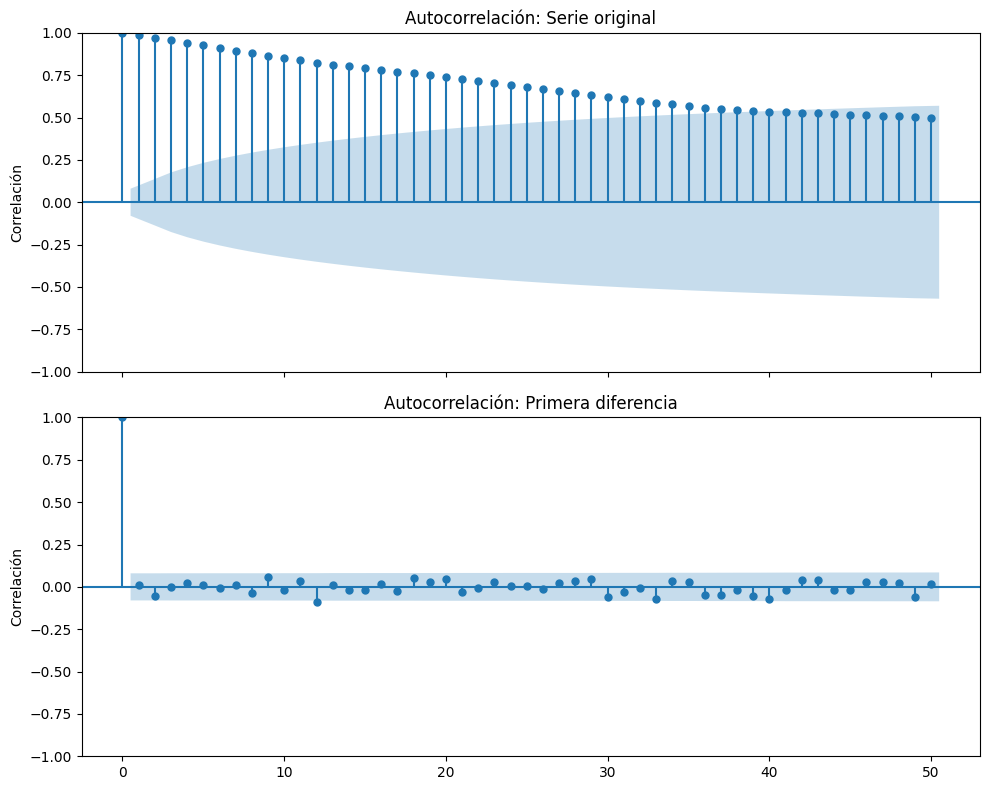

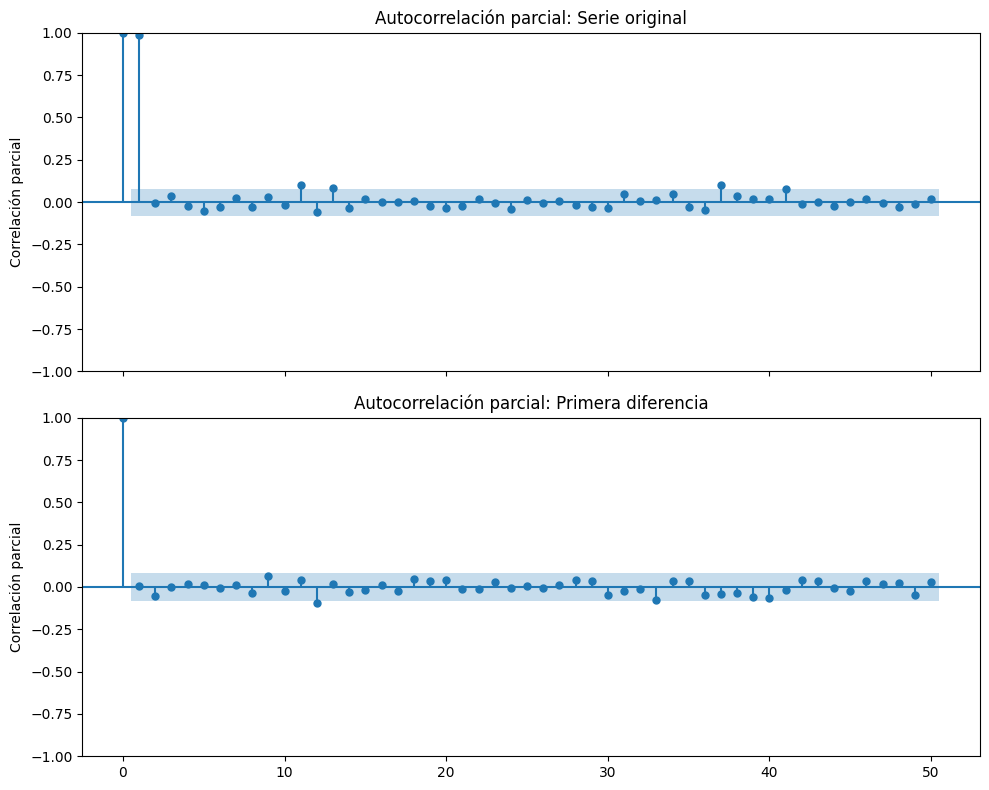

In [9]:
# ================== ANÁLISIS DE AUTOCORRELACIÓN ================== #

# Fuente de datos: https://cienciadedatos.net/documentos/py51-modelos-arima-sarimax-python

# Gráfico de autocorrelación para la serie original y la serie diferenciada
fig, axes = plt.subplots(nrows=2, ncols=1, figsize=(10, 8), sharex=True)

# Autocorrelación de la serie original
plot_acf(train_data['Adj_Close'], ax=axes[0], lags=50, alpha=0.05)
axes[0].set_title('Autocorrelación: Serie original')
axes[0].set_ylabel('Correlación')

# Autocorrelación de la primera diferencia
plot_acf(primera_diferencia, ax=axes[1], lags=50, alpha=0.05)
axes[1].set_title('Autocorrelación: Primera diferencia')
axes[1].set_ylabel('Correlación')
plt.tight_layout()
plt.show()

# Gráfico de autocorrelación parcial para la serie original y la serie diferenciada
fig, axes = plt.subplots(nrows=2, ncols=1, figsize=(10, 8), sharex=True)

# Autocorrelación parcial de la serie original
plot_pacf(train_data['Adj_Close'], ax=axes[0], lags=50, alpha=0.05, method='ywm')
axes[0].set_title('Autocorrelación parcial: Serie original')
axes[0].set_ylabel('Correlación parcial')

# Autocorrelación parcial de la primera diferencia
plot_pacf(primera_diferencia, ax=axes[1], lags=50, alpha=0.05, method='ywm')
axes[1].set_title('Autocorrelación parcial: Primera diferencia')
axes[1].set_ylabel('Correlación parcial')
plt.tight_layout()
plt.show()


In [10]:
# ================== MODELO ARIMA ================== #

# Ajustar el modelo ARIMA sobre la primera diferencia con p=1, d=0, q=1
best_params = (1, 0, 1)
arima_model = ARIMA(primera_diferencia, order=best_params)
arima_result = arima_model.fit()

# Predicción sobre los datos de prueba para la primera diferencia
arima_forecast_diff = arima_result.forecast(steps=len(test_data))

# La predicción de la primera diferencia debe sumarse acumulativamente al último valor de entrenamiento
arima_forecast = arima_forecast_diff.cumsum() + train_data['Adj_Close'].iloc[-1]

# Resumen del modelo
print("=== Resumen del Modelo ARIMA (Primera Diferencia) ===")
print(arima_result.summary())


c:\Users\ramon\AppData\Local\Programs\Python\Python313\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\ramon\AppData\Local\Programs\Python\Python313\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\ramon\AppData\Local\Programs\Python\Python313\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


=== Resumen del Modelo ARIMA (Primera Diferencia) ===
                               SARIMAX Results                                
Dep. Variable:              Adj_Close   No. Observations:                  599
Model:                 ARIMA(1, 0, 1)   Log Likelihood               -1466.198
Date:                Sun, 02 Feb 2025   AIC                           2940.396
Time:                        23:44:24   BIC                           2957.977
Sample:                             0   HQIC                          2947.240
                                - 599                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0638      0.117      0.545      0.585      -0.166       0.293
ar.L1         -0.8971      0.112     -8.038      0.000      -1.116      -0.67

c:\Users\ramon\AppData\Local\Programs\Python\Python313\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(



Métricas de Evaluación para ARIMA:
MAE: nan
MSE: 348.97
RMSE: 18.68


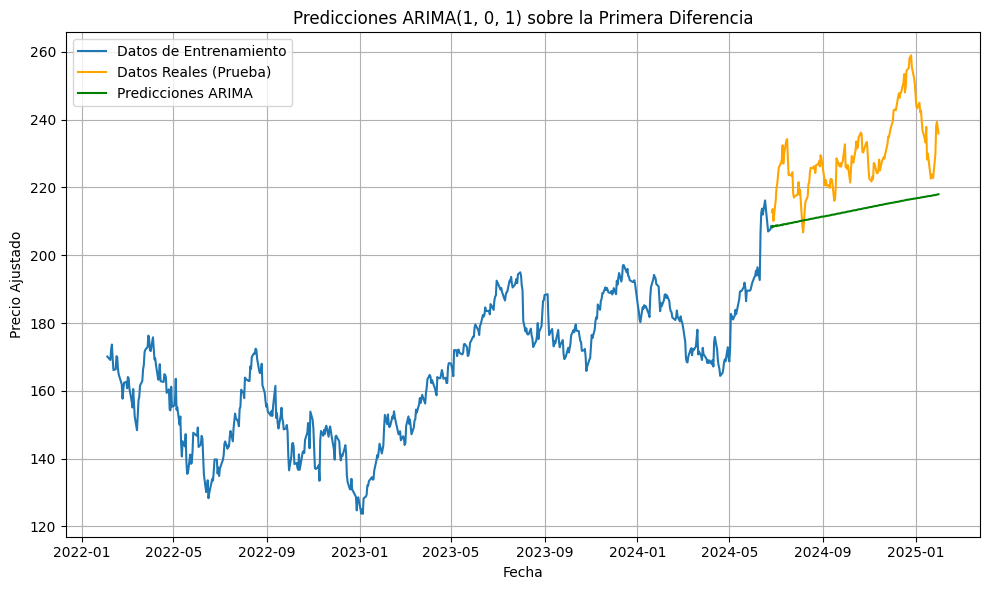

In [11]:
# MAE, MSE y RMSE para ARIMA
mae_arima = np.mean(np.abs(test_data['Adj_Close'] - arima_forecast))
mse_arima = mean_squared_error(test_data['Adj_Close'], arima_forecast)
rmse_arima = np.sqrt(mse_arima)

print("\nMétricas de Evaluación para ARIMA:")
print(f"MAE: {mae_arima:.2f}")
print(f"MSE: {mse_arima:.2f}")
print(f"RMSE: {rmse_arima:.2f}")

# Visualización de las predicciones
plt.figure(figsize=(10, 6))
plt.plot(train_data['Adj_Close'], label='Datos de Entrenamiento')
plt.plot(test_data['Adj_Close'], label='Datos Reales (Prueba)', color='orange')
plt.plot(test_data.index, arima_forecast, label='Predicciones ARIMA', color='green')
plt.title(f'Predicciones ARIMA{best_params} sobre la Primera Diferencia')
plt.xlabel('Fecha')
plt.ylabel('Precio Ajustado')
plt.legend()
plt.tight_layout()
plt.grid()
plt.show()

# XGBOOST

In [12]:
# Fuente de datos: https://www.kaggle.com/code/zeyadsayedadbullah/stock-price-prediction-using-xgboost-prophet-arima/notebook
# Fuente de datos: https://medium.com/@bugragultekin/xgboost-for-stock-price-forecasting-64f89719a8e4

# ==================  ENTRENAMIENTO Y PRUEBA PARA EL MODELO ================== #
# Se define X como las características y y como la variable objetivo
X = stock_data.drop(columns=['Adj_Close', 'Prediction', 'isFuture'])
y = stock_data['Adj_Close']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42) # Entramiento y prueba (80%-20%) para el modelo

# ==================  OPTIMIZACIÓN DE HIPERPARÁMETROS ================== #
def objective(trial):
    params = {
        'objective': 'reg:squarederror', # Función de pérdida para regresión (MSE)
        'eval_metric': 'rmse', # Métrica de evaluación (RMSE)
        'n_estimators': trial.suggest_int('n_estimators', 100, 1000), # Número de árboles 
        'max_depth': trial.suggest_int('max_depth', 3, 10), # Profundidad máxima del árbol 
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.1), # Tasa de aprendizaje 
        'subsample': trial.suggest_float('subsample', 0.6, 1.0), # Submuestra de filas 
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.6, 1.0), # Submuestra de columnas 
        'reg_alpha': trial.suggest_float('reg_alpha', 0, 10), # Regularización L1 
        'reg_lambda': trial.suggest_float('reg_lambda', 0, 10), # Regularización L2 
        'verbosity': 0, # No mostrar mensajes de entrenamiento 
    }
    
    # Entrenar el modelo con los parámetros definidos
    xgb_model = XGBRegressor(**params)
    xgb_model.fit(X_train, y_train)

    # Realizar predicciones y calcular el error RMSE
    y_pred = xgb_model.predict(X_test)
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    
    return rmse

# Crear un estudio de optimización y ejecutar 50 pruebas
study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=50)

# Mostrar los resultados de la optimización
print("\nMejores parámetros encontrados:")
print(study.best_trial.params)

# Obtener los mejores parámetros y entrenar el modelo con ellos
best_params = study.best_trial.params
xgb_best = XGBRegressor(**best_params)
xgb_best.fit(X_train, y_train)

# ==================  AGREGAR PREDICCIONES A LOS DATOS HISTÓRICOS ================== #
y_pred_test = xgb_best.predict(X_test)
stock_data.loc[X_test.index, 'Prediction'] = y_pred_test 

[I 2025-02-02 23:44:24,748] A new study created in memory with name: no-name-37eaa5bb-5e7d-4f6a-be7b-fe392f29c782


[I 2025-02-02 23:44:25,198] Trial 0 finished with value: 2.0965106356869647 and parameters: {'n_estimators': 702, 'max_depth': 3, 'learning_rate': 0.010348287164552399, 'subsample': 0.7384312945948646, 'colsample_bytree': 0.8137711315242495, 'reg_alpha': 6.038935203320074, 'reg_lambda': 4.480251644792771}. Best is trial 0 with value: 2.0965106356869647.
[I 2025-02-02 23:44:25,547] Trial 1 finished with value: 1.3506925966806242 and parameters: {'n_estimators': 880, 'max_depth': 4, 'learning_rate': 0.02732050828810905, 'subsample': 0.7251565267680157, 'colsample_bytree': 0.8724044904648346, 'reg_alpha': 6.69007253061257, 'reg_lambda': 8.327250360417919}. Best is trial 1 with value: 1.3506925966806242.
[I 2025-02-02 23:44:25,965] Trial 2 finished with value: 1.4026098083552565 and parameters: {'n_estimators': 952, 'max_depth': 5, 'learning_rate': 0.02379426314536566, 'subsample': 0.9175886099081263, 'colsample_bytree': 0.6921113343503122, 'reg_alpha': 6.508431123821712, 'reg_lambda': 5.9


Mejores parámetros encontrados:
{'n_estimators': 908, 'max_depth': 4, 'learning_rate': 0.0677310477361288, 'subsample': 0.6328658045043274, 'colsample_bytree': 0.84350784697076, 'reg_alpha': 2.097308260448367, 'reg_lambda': 5.087246320199419}


In [13]:
# ==================  PREDICCIONES FUTURAS ================== #
num_days_pred = 30 # Número de días a predecir en el futuro
start_future = stock_data.index.max() + pd.Timedelta(days=1)
end_future = start_future + pd.Timedelta(days=num_days_pred)
future_dates = pd.date_range(start=start_future, end=end_future, freq='1d')

# Crear DataFrame para los datos futuros
future_df = pd.DataFrame(index=future_dates)
future_df['isFuture'] = True

# Concatenar datos históricos y futuros
df_and_future = pd.concat([stock_data, future_df])
df_and_future = calculate_indicators(df_and_future)
df_and_future = create_features(df_and_future)

# Seleccionar características numéricas y rellenar valores nulos
future_features = df_and_future.query("isFuture").drop(columns=['Adj_Close', 'Prediction', 'isFuture'], errors='ignore')
future_features = future_features.fillna(method="ffill").fillna(0)
numeric_cols = future_features.select_dtypes(include=['number']).columns
future_features[numeric_cols] = future_features[numeric_cols].astype(float)

# Realizar predicciones y actualizar el DataFrame combinado
if len(future_features) > 0:
    predictions = xgb_best.predict(future_features)

    if len(predictions) == len(future_features):
        predictions_df = pd.DataFrame(predictions, index=future_features.index, columns=['Prediction'])
        df_and_future.update(predictions_df)
        df_and_future.loc[predictions_df.index, 'Adj_Close'] = predictions_df['Prediction']
    else:
        print(f"Error: Desajuste en tamaño de predicciones ({len(predictions)}) y filas ({len(future_features.index)})")

else:
    print("Error: No hay suficientes datos en future_features para hacer predicciones.")

In [14]:
# ==================  EVALUACIÓN DEL MODELO ================== #
def mean_absolute_percentage_error(y_true, y_pred):
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

rmse_test = np.sqrt(mean_squared_error(y_test, y_pred_test))
mape_test = mean_absolute_percentage_error(y_test, y_pred_test)

# Evaluar el rendimiento del modelo en base al umbral de error porcentual 
performance_threshold = 2  
performance_status = "Aceptable" if mape_test <= performance_threshold else "No Aceptable"

print("\n=== Evaluación del Modelo ===")
print(f"Test RMSE: {rmse_test}")
print(f"Prediction Error Percentage: {mape_test}%")
print(f"Model Performance: {performance_status}")


=== Evaluación del Modelo ===
Test RMSE: 1.1449552338996773
Prediction Error Percentage: 0.49502931077098744%
Model Performance: Aceptable


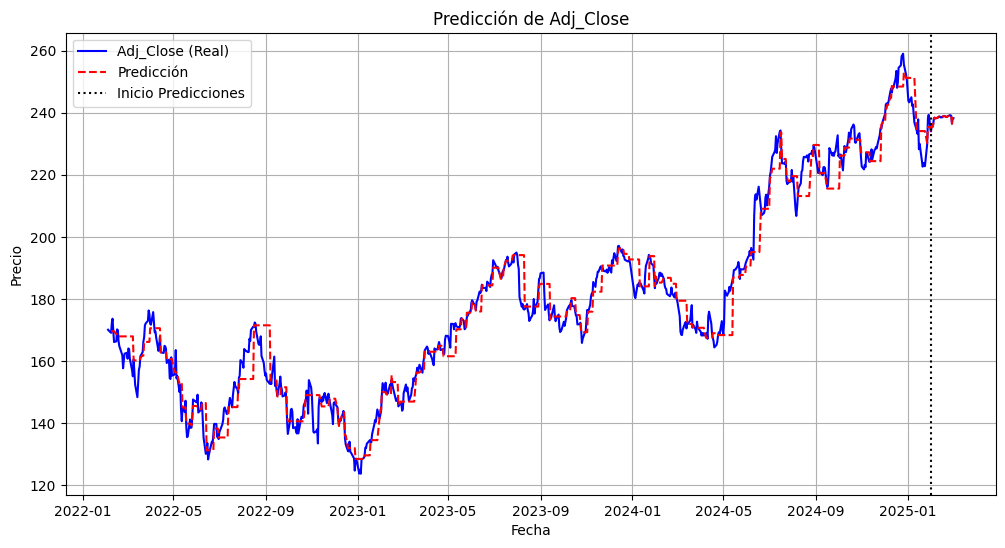

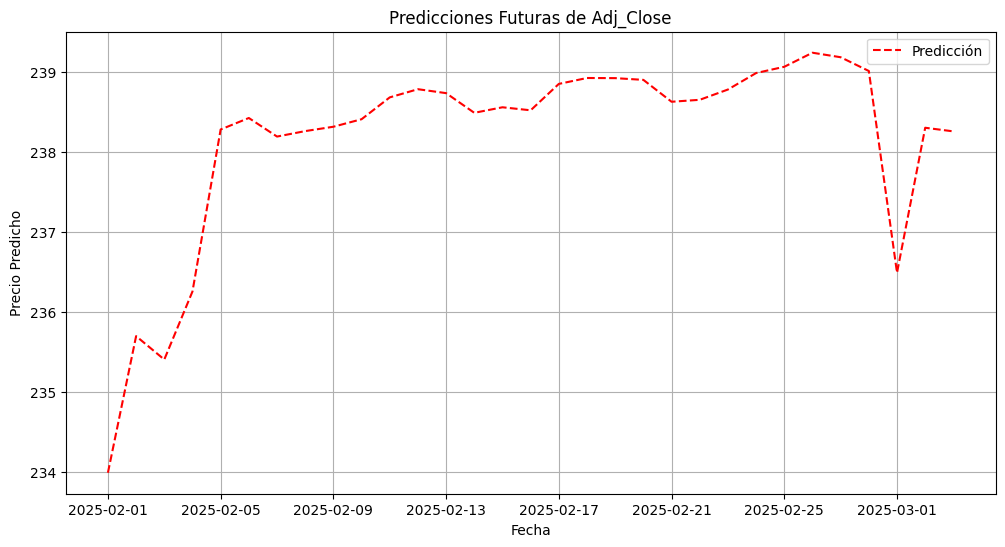

In [15]:

# ==================  VISUALIZACIÓN ================== #
# Graficar los datos históricos y las predicciones futuras
plt.figure(figsize=(12, 6))
plt.plot(df_and_future.index, df_and_future['Adj_Close'], label="Adj_Close (Real)", color='blue')
plt.plot(df_and_future.index, df_and_future['Prediction'], label="Predicción", color='red', linestyle="dashed")
plt.axvline(x=df_and_future.query("isFuture").index.min(), color='black', linestyle="dotted", label="Inicio Predicciones")
plt.xlabel("Fecha")
plt.ylabel("Precio")
plt.title("Predicción de Adj_Close")
plt.legend()
plt.grid()
plt.show()

# Graficar solo las predicciones futuras
future_predictions = df_and_future.query("isFuture")
plt.figure(figsize=(12, 6))
plt.plot(future_predictions.index, future_predictions['Prediction'], label="Predicción", color='red', linestyle="dashed")
plt.xlabel("Fecha")
plt.ylabel("Precio Predicho")
plt.title("Predicciones Futuras de Adj_Close")
plt.legend()
plt.grid()
plt.show()

# RANDOM FOREST

In [17]:
# ==================  INCORPORAR PREDICCIÓN DEL PASO 1 ================== #
df_and_future.dropna(inplace=True)  # Eliminar valores nulos

# ==================  GENERAR SEÑALES DE TRADING ================== #
def generate_trading_signals(df):
    """
    Genera señales de trading usando múltiples estrategias.
    """
    # Estrategia 1: Cruce de Medias Móviles (SMA vs EMA)
    df['Signal_SMA'] = -1  # HOLD por defecto
    df.loc[df['SMA_10'] > df['EMA_20'], 'Signal_SMA'] = 1  # BUY
    df.loc[df['SMA_10'] < df['EMA_20'], 'Signal_SMA'] = 0  # SELL

    # Estrategia 2: RSI (Sobrecompra y Sobreventa)
    df['Signal_RSI'] = -1  # HOLD por defecto
    df.loc[df['RSI'] < 30, 'Signal_RSI'] = 1  # BUY
    df.loc[df['RSI'] > 70, 'Signal_RSI'] = 0  # SELL

    # Estrategia 3: MACD (Momentum)
    df['Signal_MACD'] = -1  # HOLD por defecto
    df.loc[df['MACD'] > 0, 'Signal_MACD'] = 1  # BUY
    df.loc[df['MACD'] < 0, 'Signal_MACD'] = 0  # SELL

    return df

# Aplicar las estrategias al dataset
df_and_future = generate_trading_signals(df_and_future)

# ==================  CREAR DATASET DE MACHINE LEARNING ================== #
# Las señales se usan como objetivos Y, y todas las demás variables como características X
X = df_and_future.drop(columns=['Adj_Close', 'Signal_SMA', 'Signal_RSI', 'Signal_MACD', 'isFuture'])
y_SMA = df_and_future['Signal_SMA']
y_RSI = df_and_future['Signal_RSI']
y_MACD = df_and_future['Signal_MACD']

# Dividir en conjuntos de entrenamiento y prueba
X_train, X_test, y_train_SMA, y_test_SMA = train_test_split(X, y_SMA, test_size=0.2, random_state=42)
X_train, X_test, y_train_RSI, y_test_RSI = train_test_split(X, y_RSI, test_size=0.2, random_state=42)
X_train, X_test, y_train_MACD, y_test_MACD = train_test_split(X, y_MACD, test_size=0.2, random_state=42)

# ==================  OPTIMIZACIÓN DE RANDOM FOREST CON OPTUNA ================== #
def optimize_rf(trial):
    params = {
        'n_estimators': trial.suggest_int('n_estimators', 100, 1000), # Número de árboles
        'max_depth': trial.suggest_int('max_depth', 3, 20), # Profundidad máxima del árbol
        'min_samples_split': trial.suggest_int('min_samples_split', 2, 10), # Mínimo de muestras para dividir
        'min_samples_leaf': trial.suggest_int('min_samples_leaf', 1, 5), # Mínimo de muestras en hoja
        'max_features': trial.suggest_categorical('max_features', ['sqrt', 'log2', None]), # Máximo de características
    }
    rf_model = RandomForestClassifier(**params, random_state=42, n_jobs=-1) 
    rf_model.fit(X_train, y_train_SMA)
    y_pred = rf_model.predict(X_test)
    accuracy = accuracy_score(y_test_SMA, y_pred)
    return accuracy

study = optuna.create_study(direction='maximize')
study.optimize(optimize_rf, n_trials=50)

best_params = study.best_trial.params

# ==================  ENTRENAR MODELOS RANDOM FOREST PARA CADA ESTRATEGIA ================== #
rf_SMA = RandomForestClassifier(**best_params, random_state=42, n_jobs=-1)
rf_RSI = RandomForestClassifier(**best_params, random_state=42, n_jobs=-1)
rf_MACD = RandomForestClassifier(**best_params, random_state=42, n_jobs=-1)

rf_SMA.fit(X_train, y_train_SMA)
rf_RSI.fit(X_train, y_train_RSI)
rf_MACD.fit(X_train, y_train_MACD)

# ==================  PREDICCIÓN ================== #
df_and_future['Predicted_SMA'] = rf_SMA.predict(X)
df_and_future['Predicted_RSI'] = rf_RSI.predict(X)
df_and_future['Predicted_MACD'] = rf_MACD.predict(X)

[I 2025-02-02 23:45:53,655] A new study created in memory with name: no-name-466056e1-ec77-43ef-beb5-4aa3b54a3071
[I 2025-02-02 23:45:54,753] Trial 0 finished with value: 0.9342105263157895 and parameters: {'n_estimators': 913, 'max_depth': 9, 'min_samples_split': 10, 'min_samples_leaf': 1, 'max_features': 'sqrt'}. Best is trial 0 with value: 0.9342105263157895.
[I 2025-02-02 23:45:55,774] Trial 1 finished with value: 0.9276315789473685 and parameters: {'n_estimators': 853, 'max_depth': 8, 'min_samples_split': 10, 'min_samples_leaf': 2, 'max_features': 'log2'}. Best is trial 0 with value: 0.9342105263157895.
[I 2025-02-02 23:45:56,121] Trial 2 finished with value: 0.9078947368421053 and parameters: {'n_estimators': 259, 'max_depth': 14, 'min_samples_split': 8, 'min_samples_leaf': 5, 'max_features': None}. Best is trial 0 with value: 0.9342105263157895.
[I 2025-02-02 23:45:56,818] Trial 3 finished with value: 0.9276315789473685 and parameters: {'n_estimators': 436, 'max_depth': 15, 'min

Optimized Parameters: {'n_estimators': 785, 'max_depth': 14, 'min_samples_split': 4, 'min_samples_leaf': 1, 'max_features': 'sqrt'}


Evaluación de los Modelos:
Test Accuracy (SMA): 0.9473684210526315
Test Accuracy (RSI): 0.9802631578947368
Test Accuracy (MACD): 1.0




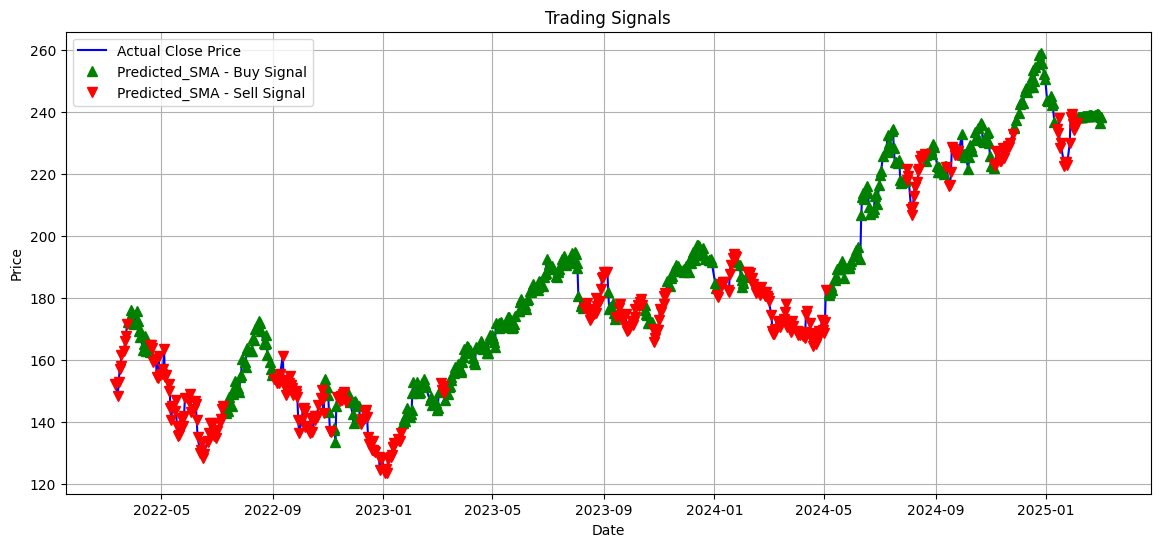

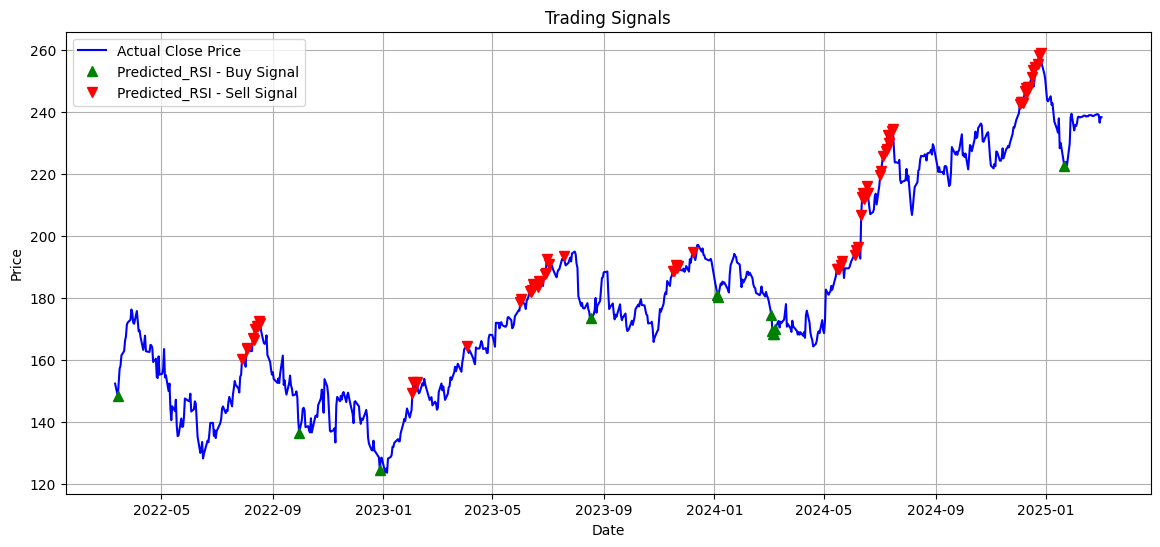

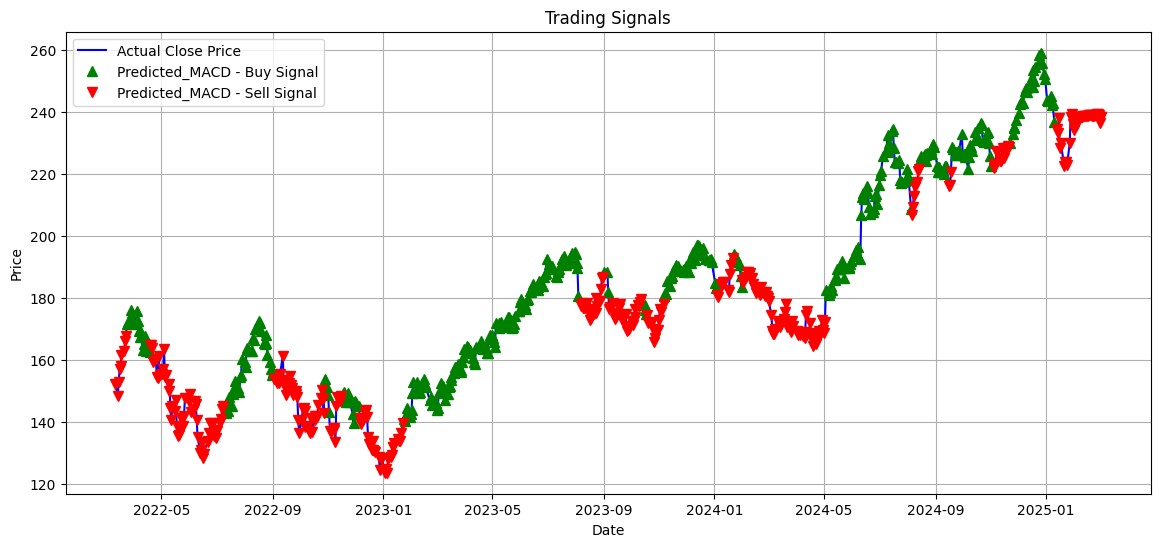

In [18]:
# ==================  EVALUACIÓN DE LOS MODELOS ================== #
print("Optimized Parameters:", best_params)
print("\n")

print("Evaluación de los Modelos:")
print(f"Test Accuracy (SMA): {accuracy_score(y_test_SMA, rf_SMA.predict(X_test))}")
print(f"Test Accuracy (RSI): {accuracy_score(y_test_RSI, rf_RSI.predict(X_test))}")
print(f"Test Accuracy (MACD): {accuracy_score(y_test_MACD, rf_MACD.predict(X_test))}")
print("\n")

# ==================  VISUALIZACIÓN ================== #
for col in ['Predicted_SMA', 'Predicted_RSI', 'Predicted_MACD']:
    plt.figure(figsize=(14,6))
    plt.plot(df_and_future.index, df_and_future['Adj_Close'], label='Actual Close Price', color='blue')
    plt.plot(df_and_future.index, df_and_future['Adj_Close'].where(df_and_future[col] == 1), 
             '^', markersize=7, color='green', lw=0, label=f'{col} - Buy Signal')
    plt.plot(df_and_future.index, df_and_future['Adj_Close'].where(df_and_future[col] == 0), 
             'v', markersize=7, color='red', lw=0, label=f'{col} - Sell Signal')
    plt.title('Trading Signals')
    plt.xlabel('Date')
    plt.ylabel('Price')
    plt.legend()
    plt.grid()
    plt.show()

# BACKTESTING

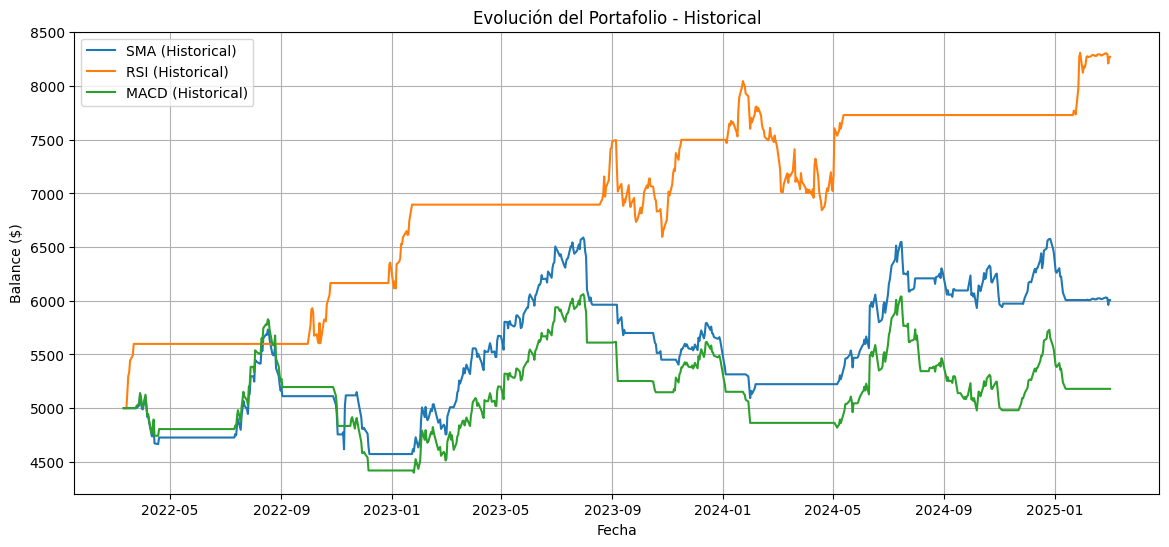

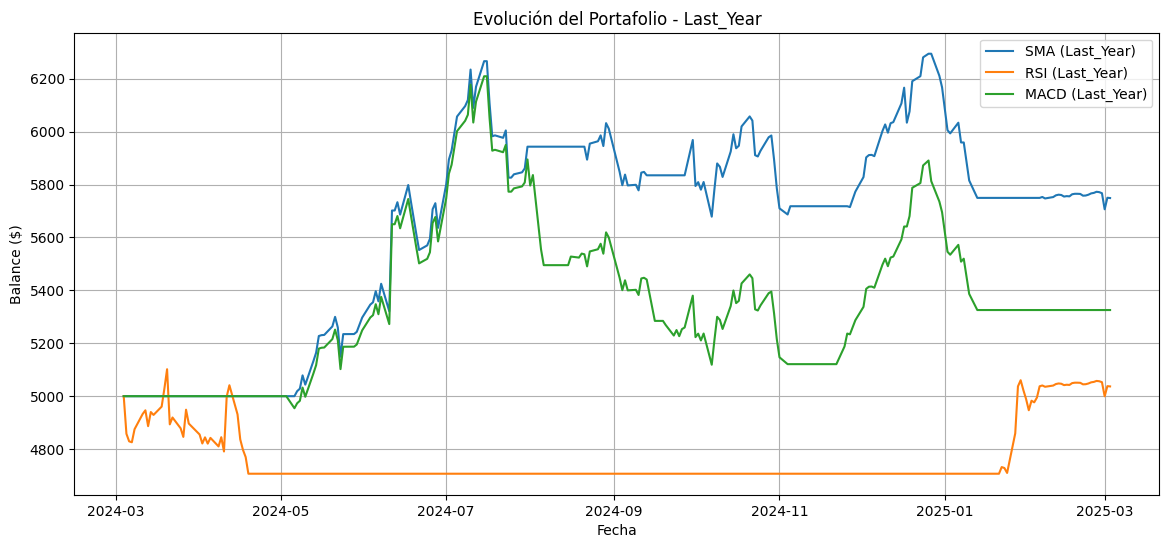

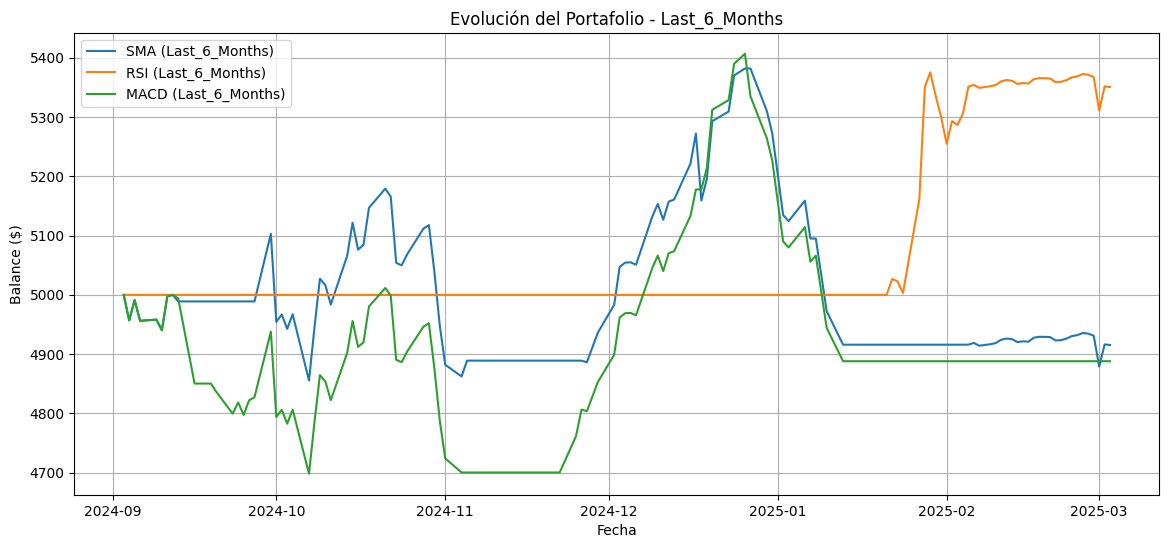

  DatetimeIndex  Precio_Activo  Valor_Portafolio     Periodo  Estrategia_ID  \
0    2022-03-11     152.430222            5000.0  Historical              1   
1    2022-03-14     148.381302            5000.0  Historical              1   
2    2022-03-15     152.784836            5000.0  Historical              1   
3    2022-03-16     157.217987            5000.0  Historical              1   
4    2022-03-17     158.232697            5000.0  Historical              1   

  Estrategia_Nombre  
0               SMA  
1               SMA  
2               SMA  
3               SMA  
4               SMA  


In [ ]:
# ==================  CONFIGURACIÓN DEL BACKTESTING ================== #
initial_balance = 5000  # Capital inicial en dólares
trading_fee = 0.001  # Comisión por transacción (0.1%)
stop_loss = 0.05  # Stop loss del 5%
take_profit = 0.10  # Take profit del 10%

# ==================  FUNCIÓN DE BACKTESTING ================== #
def backtest_strategy(df, strategy_column, initial_balance, trading_fee, stop_loss, take_profit):
    balance = initial_balance
    shares = 0  # Número de acciones en cartera
    balance_history = []
    positions = []
    entry_price = 0
    
    for index, row in df.iterrows():
        price = row['Adj_Close']
        signal = row[strategy_column]

        if signal == 1 and balance > 0:  # BUY
            shares = balance / price
            balance = 0
            entry_price = price
            positions.append((index, price, 'BUY'))

        elif signal == 0 and shares > 0:  # SELL
            balance = shares * price * (1 - trading_fee)
            shares = 0
            positions.append((index, price, 'SELL'))

        elif shares > 0:  # Verificar stop-loss y take-profit
            change = (price - entry_price) / entry_price
            if change <= -stop_loss:
                balance = shares * price * (1 - trading_fee)
                shares = 0
                positions.append((index, price, 'STOP-LOSS SELL'))
            elif change >= take_profit:
                balance = shares * price * (1 - trading_fee)
                shares = 0
                positions.append((index, price, 'TAKE-PROFIT SELL'))

        current_value = balance + (shares * price)
        balance_history.append(current_value)

    df[f'Portfolio_Value_{strategy_column}'] = balance_history
    return df, positions

# ==================  FILTRAR DATOS POR PERÍODO ================== #
def filter_data_by_period(df, period):
    if period == 'Historical':
        return df.copy()
    elif period == 'Last_Year':
        return df[df.index >= df.index.max() - pd.DateOffset(years=1)]
    elif period == 'Last_6_Months':
        return df[df.index >= df.index.max() - pd.DateOffset(months=6)]
    else:
        raise ValueError("Período no válido. Usa 'Historical', 'Last_Year' o 'Last_6_Months'")

# ==================  APLICAR BACKTESTING A TODAS LAS ESTRATEGIAS ================== #
strategies = ['Predicted_SMA', 'Predicted_RSI', 'Predicted_MACD']
backtest_results = df_and_future.copy()

positions_dict = {} 

for strategy in strategies:
    backtest_results, positions = backtest_strategy(backtest_results, strategy, initial_balance, trading_fee, stop_loss, take_profit)
    positions_dict[strategy] = positions  # Guardamos las posiciones para análisis posterior

# ==================  APLICAR BACKTESTING A DIFERENTES PERÍODOS ================== #
periods = ['Historical', 'Last_Year', 'Last_6_Months']
backtest_results_by_period = {}
positions_dict_by_period = {}

for period in periods:
    df_filtered = filter_data_by_period(df_and_future, period)
    backtest_results_by_period[period] = df_filtered.copy()
    positions_dict_by_period[period] = {}
    
    for strategy in strategies:
        backtest_results_by_period[period], positions = backtest_strategy(backtest_results_by_period[period], strategy, initial_balance, trading_fee, stop_loss, take_profit)
        positions_dict_by_period[period][strategy] = positions

# ==================  CREACIÓN DEL DATASET PARA POWER BI ================== #
estrategia_ids = {
    'Predicted_SMA': 1,
    'Predicted_RSI': 2,
    'Predicted_MACD': 3
}

fact_portafolio = []

for period, df in backtest_results_by_period.items():
    for strategy in strategies:
        df_temp = df[['Adj_Close', f'Portfolio_Value_{strategy}']].copy()
        df_temp = df_temp.reset_index()
        df_temp['Periodo'] = period
        df_temp['Estrategia_ID'] = estrategia_ids[strategy]
        df_temp['Estrategia_Nombre'] = strategy.replace("Predicted_", "")
        df_temp.rename(columns={'index': 'DatetimeIndex', 'Adj_Close': 'Precio_Activo', f'Portfolio_Value_{strategy}': 'Valor_Portafolio'}, inplace=True)
        fact_portafolio.append(df_temp)

fact_portafolio = pd.concat(fact_portafolio, ignore_index=True)

# ==================  EXPORTAR RESULTADOS PARA POWER BI ================== #
backtest_results.to_csv("backtest_results.csv", index=True)
fact_portafolio.to_csv("Fact_portafolio.csv", index=False)

# ==================  VISUALIZACIÓN DE RESULTADOS ================== #
for period in periods:
    plt.figure(figsize=(14, 6))
    for strategy in strategies:
        plt.plot(backtest_results_by_period[period].index, backtest_results_by_period[period][f'Portfolio_Value_{strategy}'], label=f'{strategy.replace("Predicted_", "")} ({period})')
    plt.title(f'Evolución del Portafolio - {period}')
    plt.xlabel('Fecha')
    plt.ylabel('Balance ($)')
    plt.legend()
    plt.grid()
    plt.show()

print(fact_portafolio.head())


In [22]:
# ==================  FUNCIÓN PARA MÉTRICAS DE PERFORMANCE ================== #
def calculate_performance_metrics(df, strategy_column, initial_balance):
    """
    Calcula métricas de rendimiento para una estrategia específica.
    :param df: DataFrame con el balance del portafolio en cada momento.
    :param strategy_column: Nombre de la columna de balance de la estrategia a evaluar.
    :param initial_balance: Capital inicial de la estrategia.
    :return: Diccionario con métricas de rendimiento.
    """
    final_balance = df[strategy_column].iloc[-1]
    total_return = (final_balance - initial_balance) / initial_balance
    annualized_return = ((1 + total_return) ** (252 / len(df))) - 1  # Suponiendo 252 días de trading al año

    # Calcular máximo drawdown
    rolling_max = df[strategy_column].cummax()
    drawdown = (df[strategy_column] - rolling_max) / rolling_max
    max_drawdown = drawdown.min()

    # Ratio de Sharpe (riesgo-retorno)
    daily_returns = df[strategy_column].pct_change().dropna()
    sharpe_ratio = np.mean(daily_returns) / np.std(daily_returns) * np.sqrt(252) if np.std(daily_returns) > 0 else 0

    # Ratio de Sortino (similar a Sharpe, pero solo penaliza retornos negativos)
    downside_returns = daily_returns[daily_returns < 0]
    sortino_ratio = np.mean(daily_returns) / np.std(downside_returns) * np.sqrt(252) if np.std(downside_returns) > 0 else 0

    return {
        "Final Balance": final_balance,
        "Total Return": total_return,
        "Annualized Return": annualized_return,
        "Max Drawdown": max_drawdown,
        "Sharpe Ratio": sharpe_ratio,
        "Sortino Ratio": sortino_ratio
    }

# ==================  VISUALIZAR MÉTRICAS PARA CADA ESTRATEGIA POR CADA PERÍODO ================== #
performance_metrics = {}
for period in periods:
    performance_metrics[period] = {}
    for strategy in strategies:
        metrics = calculate_performance_metrics(backtest_results_by_period[period], f'Portfolio_Value_{strategy}', initial_balance)
        performance_metrics[period][strategy] = metrics

# Visualizar métricas de rendimiento
for period, metrics_dict in performance_metrics.items():
    print(f"=== Métricas de Rendimiento ({period}) ===")
    for strategy, metrics in metrics_dict.items():
        print(f"--- Estrategia: {strategy.replace('Predicted_', '')} ---")
        for metric, value in metrics.items():
            print(f"{metric}: {value:.4f}")
        print("\n")

=== Métricas de Rendimiento (Historical) ===
--- Estrategia: SMA ---
Final Balance: 6006.1322
Total Return: 0.2012
Annualized Return: 0.0629
Max Drawdown: -0.2270
Sharpe Ratio: 0.4509
Sortino Ratio: 0.5261


--- Estrategia: RSI ---
Final Balance: 8271.7872
Total Return: 0.6544
Annualized Return: 0.1824
Max Drawdown: -0.1494
Sharpe Ratio: 1.3939
Sortino Ratio: 1.1968


--- Estrategia: MACD ---
Final Balance: 5179.7425
Total Return: 0.0359
Annualized Return: 0.0118
Max Drawdown: -0.2452
Sharpe Ratio: 0.1536
Sortino Ratio: 0.1671


=== Métricas de Rendimiento (Last_Year) ===
--- Estrategia: SMA ---
Final Balance: 5749.1288
Total Return: 0.1498
Annualized Return: 0.1443
Max Drawdown: -0.0938
Sharpe Ratio: 0.9555
Sortino Ratio: 1.0318


--- Estrategia: RSI ---
Final Balance: 5036.9670
Total Return: 0.0074
Annualized Return: 0.0071
Max Drawdown: -0.0774
Sharpe Ratio: 0.1210
Sortino Ratio: 0.0896


--- Estrategia: MACD ---
Final Balance: 5325.7198
Total Return: 0.0651
Annualized Return: 0.062

# TABLAS MODELO POWER BI

In [21]:
# ==================  CARGAR CSV ================== #
df = pd.read_csv("backtest_results.csv", index_col=0, parse_dates=True)
df_portafolio = pd.read_csv("fact_portafolio.csv", parse_dates=True)
df["Activo"] = stock_ticker  

# ==================  CREAR TABLAS PARA POWER BI ================== #

# Fact_TradingData (Tabla de hechos principal con los datos de trading)
fact_trading_data = df.copy()
fact_trading_data.index.name = "DatetimeIndex"

# Fact_Portafolio (Tabla de valores del portafolio)
fact_portafolio = df_portafolio.copy()

# Dim_Fecha (Tabla de dimensión de fechas)
dim_fecha = df[["dayofweek", "month", "dayofyear", "dayofmonth", "weekofyear"]].drop_duplicates().copy()
dim_fecha.index.name = "DatetimeIndex"

# Dim_Indicadores (Tabla con la lista de indicadores técnicos)
dim_indicadores = pd.DataFrame({
    "Indicador_ID": [1, 2, 3, 4],
    "Indicador": ["SMA_10", "EMA_20", "RSI", "MACD"]
})

# Dim_EstrategiasTipo (Tabla con las estrategias)
dim_estrategias_tipo = pd.DataFrame({
    "Estrategia_ID": [1, 2, 3],
    "Estrategia_Nombre": ["SMA", "RSI", "MACD"]
})

# Dim_Periodos (Tabla con los períodos de backtesting)
dim_periodos = pd.DataFrame({
    "Periodo_ID": [1, 2, 3],
    "Periodo": ["Historical", "Last_Year", "Last_6_Months"]
})

# Dim_Activos (Lista única de activos disponibles)
dim_activos = pd.DataFrame({"Activo": [stock_ticker]})
dim_activos.insert(0, "Activo_ID", range(1, len(dim_activos) + 1))

# Dim_Tipo_Prediccion
dim_prediccion = pd.DataFrame({
    "Prediccion_ID": [1, 2],
    "Prediccion_DS": ["Predicción Futura", "Historico"],
    "Prediccion": [True, False]
})

# ==================  EXPORTAR A CSV PARA POWER BI ================== #
fact_trading_data.to_csv("Fact_TradingData.csv", index=True)
dim_fecha.to_csv("Dim_Fecha.csv", index=True)
dim_indicadores.to_csv("Dim_Indicadores.csv", index=False)
dim_estrategias_tipo.to_csv("Dim_EstrategiasTipo.csv", index=False)
dim_periodos.to_csv("Dim_Periodos.csv", index=False)
dim_activos.to_csv("Dim_Activos.csv", index=False)
fact_portafolio.to_csv("Fact_Portafolio.csv", index=False)
dim_prediccion.to_csv("Dim_Tipo_Prediccion.csv", index=False)

print(f"Tablas creadas y exportadas correctamente para el activo: {stock_ticker}")

Tablas creadas y exportadas correctamente para el activo: AAPL
